<a href="https://colab.research.google.com/github/siyanLearner/Cifar-100-Loading/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tarfile
import pickle
import random
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load and Preprocess Data

In [2]:
cifar10_dataset_folder_path = '/h/siyanzzzz/Desktop/cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

"""
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""

'\n    check if the data (zip) file is already downloaded\n    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz\n'

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cifar10 (transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays corresponding to each batch_id
        : `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    fpath = os.path.join(path, 'data_batch_' + str(i))
    data, labels = load_batch(fpath)
    x_train[(batch_id - 1) * 10000: batch_id * 10000, :, :, :] = data
    y_train[(batch_id - 1) * 10000: batch_id * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x
  
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open('data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels
  
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


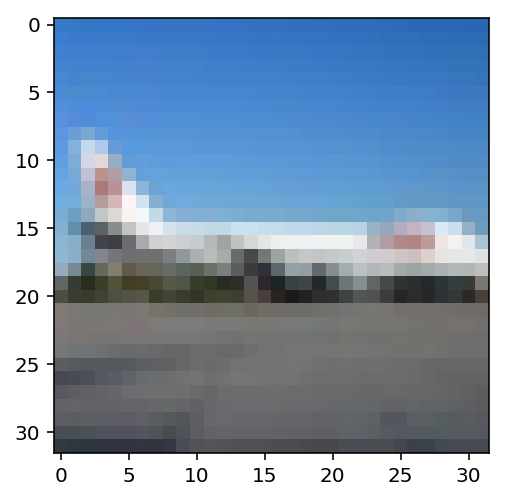

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


In [0]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)
  
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open('test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [0]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

In [0]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()
# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')



# Functions

In [0]:

def Batch_normalization(x,gamma,beta):
  mu = np.mean (x, axis=0)
  var = np.var (x, axis=0)
  x_bar = (x - mu) / np.sqrt(var + 1e-8)
  out = gamma * x_bar + beta
  #unfinished
  return out

def activation(x):
  #return tf.nn.sigmoid(x)
 # return tf.nn.tanh(x)
  return tf.nn.relu(x)

def fully_con(tensor,outputsize):
  # Weights and bias
    initializer=tf.contrib.layers.xavier_initializer()
  #  W = tf.Variable(tf.truncated_normal([int(tensor.shape[1]), outputsize], stddev=.05))
    #W = tf.Variable(tf.zeros([int(tensor.shape[1]),outputsize]))
    W = tf.Variable(initializer(shape=[int(tensor.shape[1]),outputsize]))
    b = tf.Variable(tf.zeros([outputsize]))
    x = tf.add(tf.matmul(tensor, W), b)
   
    return activation(x)

def output(tensor, outputsize):
  W = tf.Variable(tf.truncated_normal([int(tensor.shape[1]),outputsize],stddev=.05))
  b = tf.Variable(tf.zeros([outputsize]))
  
  return tf.add(tf.matmul(tensor,W),b)



In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })
    
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    T_loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    V_loss = sess.run(cost, 
                    feed_dict={
                        x: valid_features,
                        y: valid_labels,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    train_acc = sess.run(accuracy, 
                         feed_dict={
                             x: feature_batch,
                             y: label_batch,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(T_loss, valid_acc))
    return T_loss, V_loss, train_acc, valid_acc

In [0]:
def convs_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

In [0]:
def conv_net(x,keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))
    # 2. Zeros
#     conv1_filter = tf.Variable(tf.zeros([3, 3, 3, 64])) 
#     conv2_filter = tf.Variable(tf.zeros([3, 3, 64, 128])) 
#     conv3_filter = tf.Variable(tf.zeros([5, 5, 128, 256])) 
#     conv4_filter = tf.Variable(tf.zeros([5, 5, 256, 512])) 
  
#     # 3. Xavier
   # initializer=tf.contrib.layers.xavier_initializer()
#     conv1_filter = tf.Variable(initializer(shape=[3, 3, 3, 64]))
#     conv2_filter = tf.Variable(initializer(shape=[3, 3, 64, 128]))                 
#     conv3_filter = tf.Variable(initializer(shape=[5, 5, 128, 256]))
#     conv4_filter = tf.Variable(initializer(shape=[5, 5, 256, 512]))

    biases = {
      #bias for kernels
        
      #random_normal biases
      'r1': tf.Variable(tf.truncated_normal([64],mean=0,stddev=0.08)),
      'r2': tf.Variable(tf.truncated_normal([128],mean=0,stddev=0.08)),
      'r3': tf.Variable(tf.truncated_normal([256],mean=0,stddev=0.08)),
      'r4': tf.Variable(tf.truncated_normal([512],mean=0,stddev=0.08)),
     
      #zeros biases
      'z1': tf.Variable(tf.zeros([64])),
      'z2': tf.Variable(tf.zeros([128])),
      'z3': tf.Variable(tf.zeros([256])),
      'z4': tf.Variable(tf.zeros([512])),
      
#       #Xavier biases
#       'x1': tf.Variable(initializer([64])),
#       'x2': tf.Variable(initializer([128])),
#       'x3': tf.Variable(initializer([256])),
#       'x4': tf.Variable(initializer([512]))
    }
   
    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1,biases['z1'])
    conv1 = activation(conv1)
#     conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1 = tf.layers.batch_normalization(conv1)
    print('conv1:{}'.format(conv1.shape))
    # 3, 4
    conv2 = tf.nn.conv2d(conv1, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.bias_add(conv2,biases['z2'])
    conv2 = activation(conv2)
   # conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2 = tf.layers.batch_normalization(conv2)
    print('conv2:{}'.format(conv2.shape))
    # 5, 6
    conv3 = tf.nn.conv2d(conv2, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.bias_add(conv3,biases['z3'])
    conv3 = activation(conv3)
    #conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3 = tf.layers.batch_normalization(conv3)
    print('conv3:{}'.format(conv3.shape))
    # 7, 8
    conv4 = tf.nn.conv2d(conv3, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.bias_add(conv4,biases['z4'])
    conv4 = activation(conv4)
    #conv4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4= tf.layers.batch_normalization(conv4)
    print('conv4:{}'.format(conv4.shape))
    # 9
    flat = tf.contrib.layers.flatten(conv4)  
    print('flat:{}'.format(flat.shape))
    full1 = fully_con(flat,256)
    #full1 = tf.nn.dropout(full1, keep_prob)
    
    full2 = fully_con(full1,512)
    #full2 = tf.nn.dropout(full1, keep_prob)
    
    full3 = fully_con(full2,1024)
    #full3 = tf.nn.dropout(full1, keep_prob)
    
    #out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    out = output(full3,10)
    return out

# Hyperparameters

In [0]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

# Training
**bold text**

In [45]:
logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate,0.9).minimize(cost)                                              

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

conv1:(?, 16, 16, 64)
conv2:(?, 8, 8, 128)
conv3:(?, 4, 4, 256)
conv4:(?, 2, 2, 512)
flat:(?, 2048)


In [49]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            T_loss, V_loss, train_acc, valid_acc = print_stats(sess, batch_features, batch_labels, cost, accuracy)
            train_losses.append(T_loss)
            valid_losses.append(V_loss)
            train_accs.append(train_acc)
            valid_accs.append(valid_acc)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1668 Validation Accuracy: 0.267400
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.0902 Validation Accuracy: 0.291200
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7884 Validation Accuracy: 0.313000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.7899 Validation Accuracy: 0.367400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.8202 Validation Accuracy: 0.377600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.9149 Validation Accuracy: 0.386000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.8262 Validation Accuracy: 0.403400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.4606 Validation Accuracy: 0.417000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.5030 Validation Accuracy: 0.428000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.5699 Validation Accuracy: 0.439200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7778 Validation Accuracy: 0.449000
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.6657 Validation Accuracy: 0.468200
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.3035 Validation Accuracy: 0.445600


# Plot

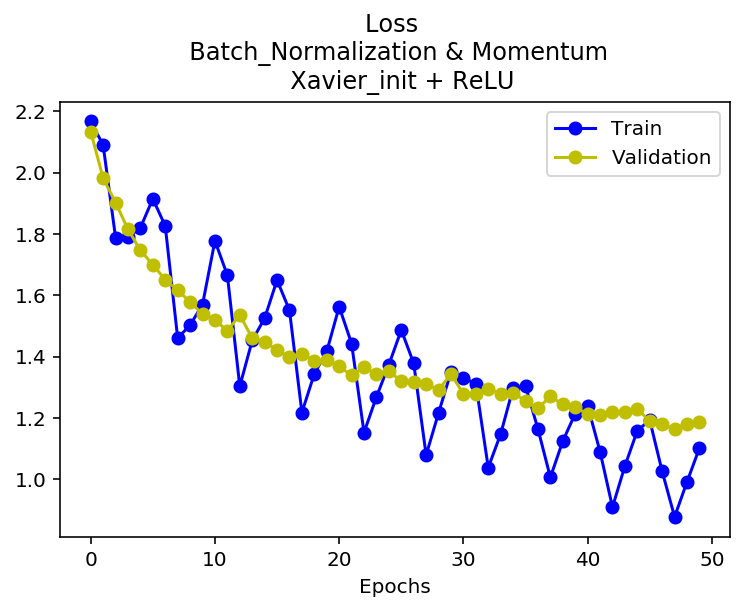

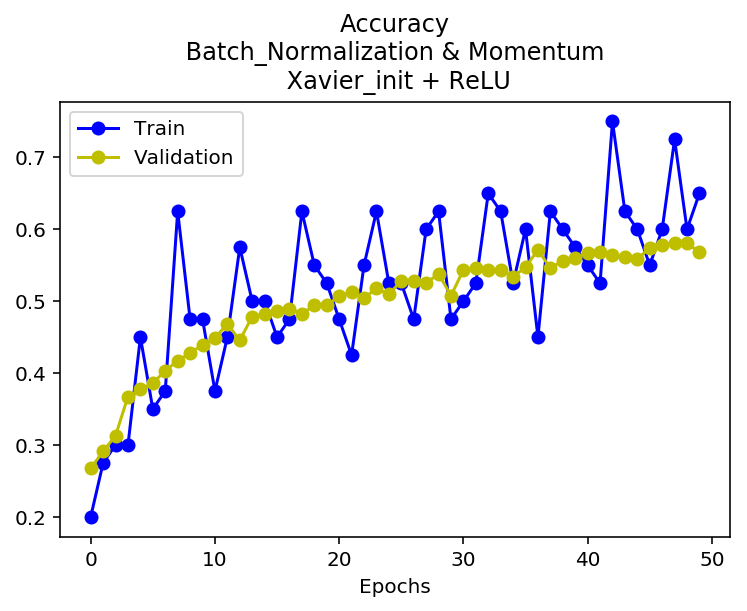

In [50]:
# Plot training curve
    plt.figure()
    plt.plot(train_losses, 'bo-', label="Train")
    plt.plot(valid_losses, 'yo-', label="Validation")
    plt.legend()
    plt.title("Loss \n  Batch_Normalization & Momentum \n  Xavier_init + ReLU")
    plt.xlabel("Epochs")
    plt.show()
    plt.close()
    
    plt.figure()
    plt.plot(train_accs, 'bo-',label="Train")
    plt.plot(valid_accs, 'yo-',label="Validation")
    plt.legend()
    plt.title("Accuracy\n Batch_Normalization & Momentum \n Xavier_init + ReLU")
    plt.xlabel("Epochs")
    plt.show()
    plt.close()
    
    

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.09982085987261147



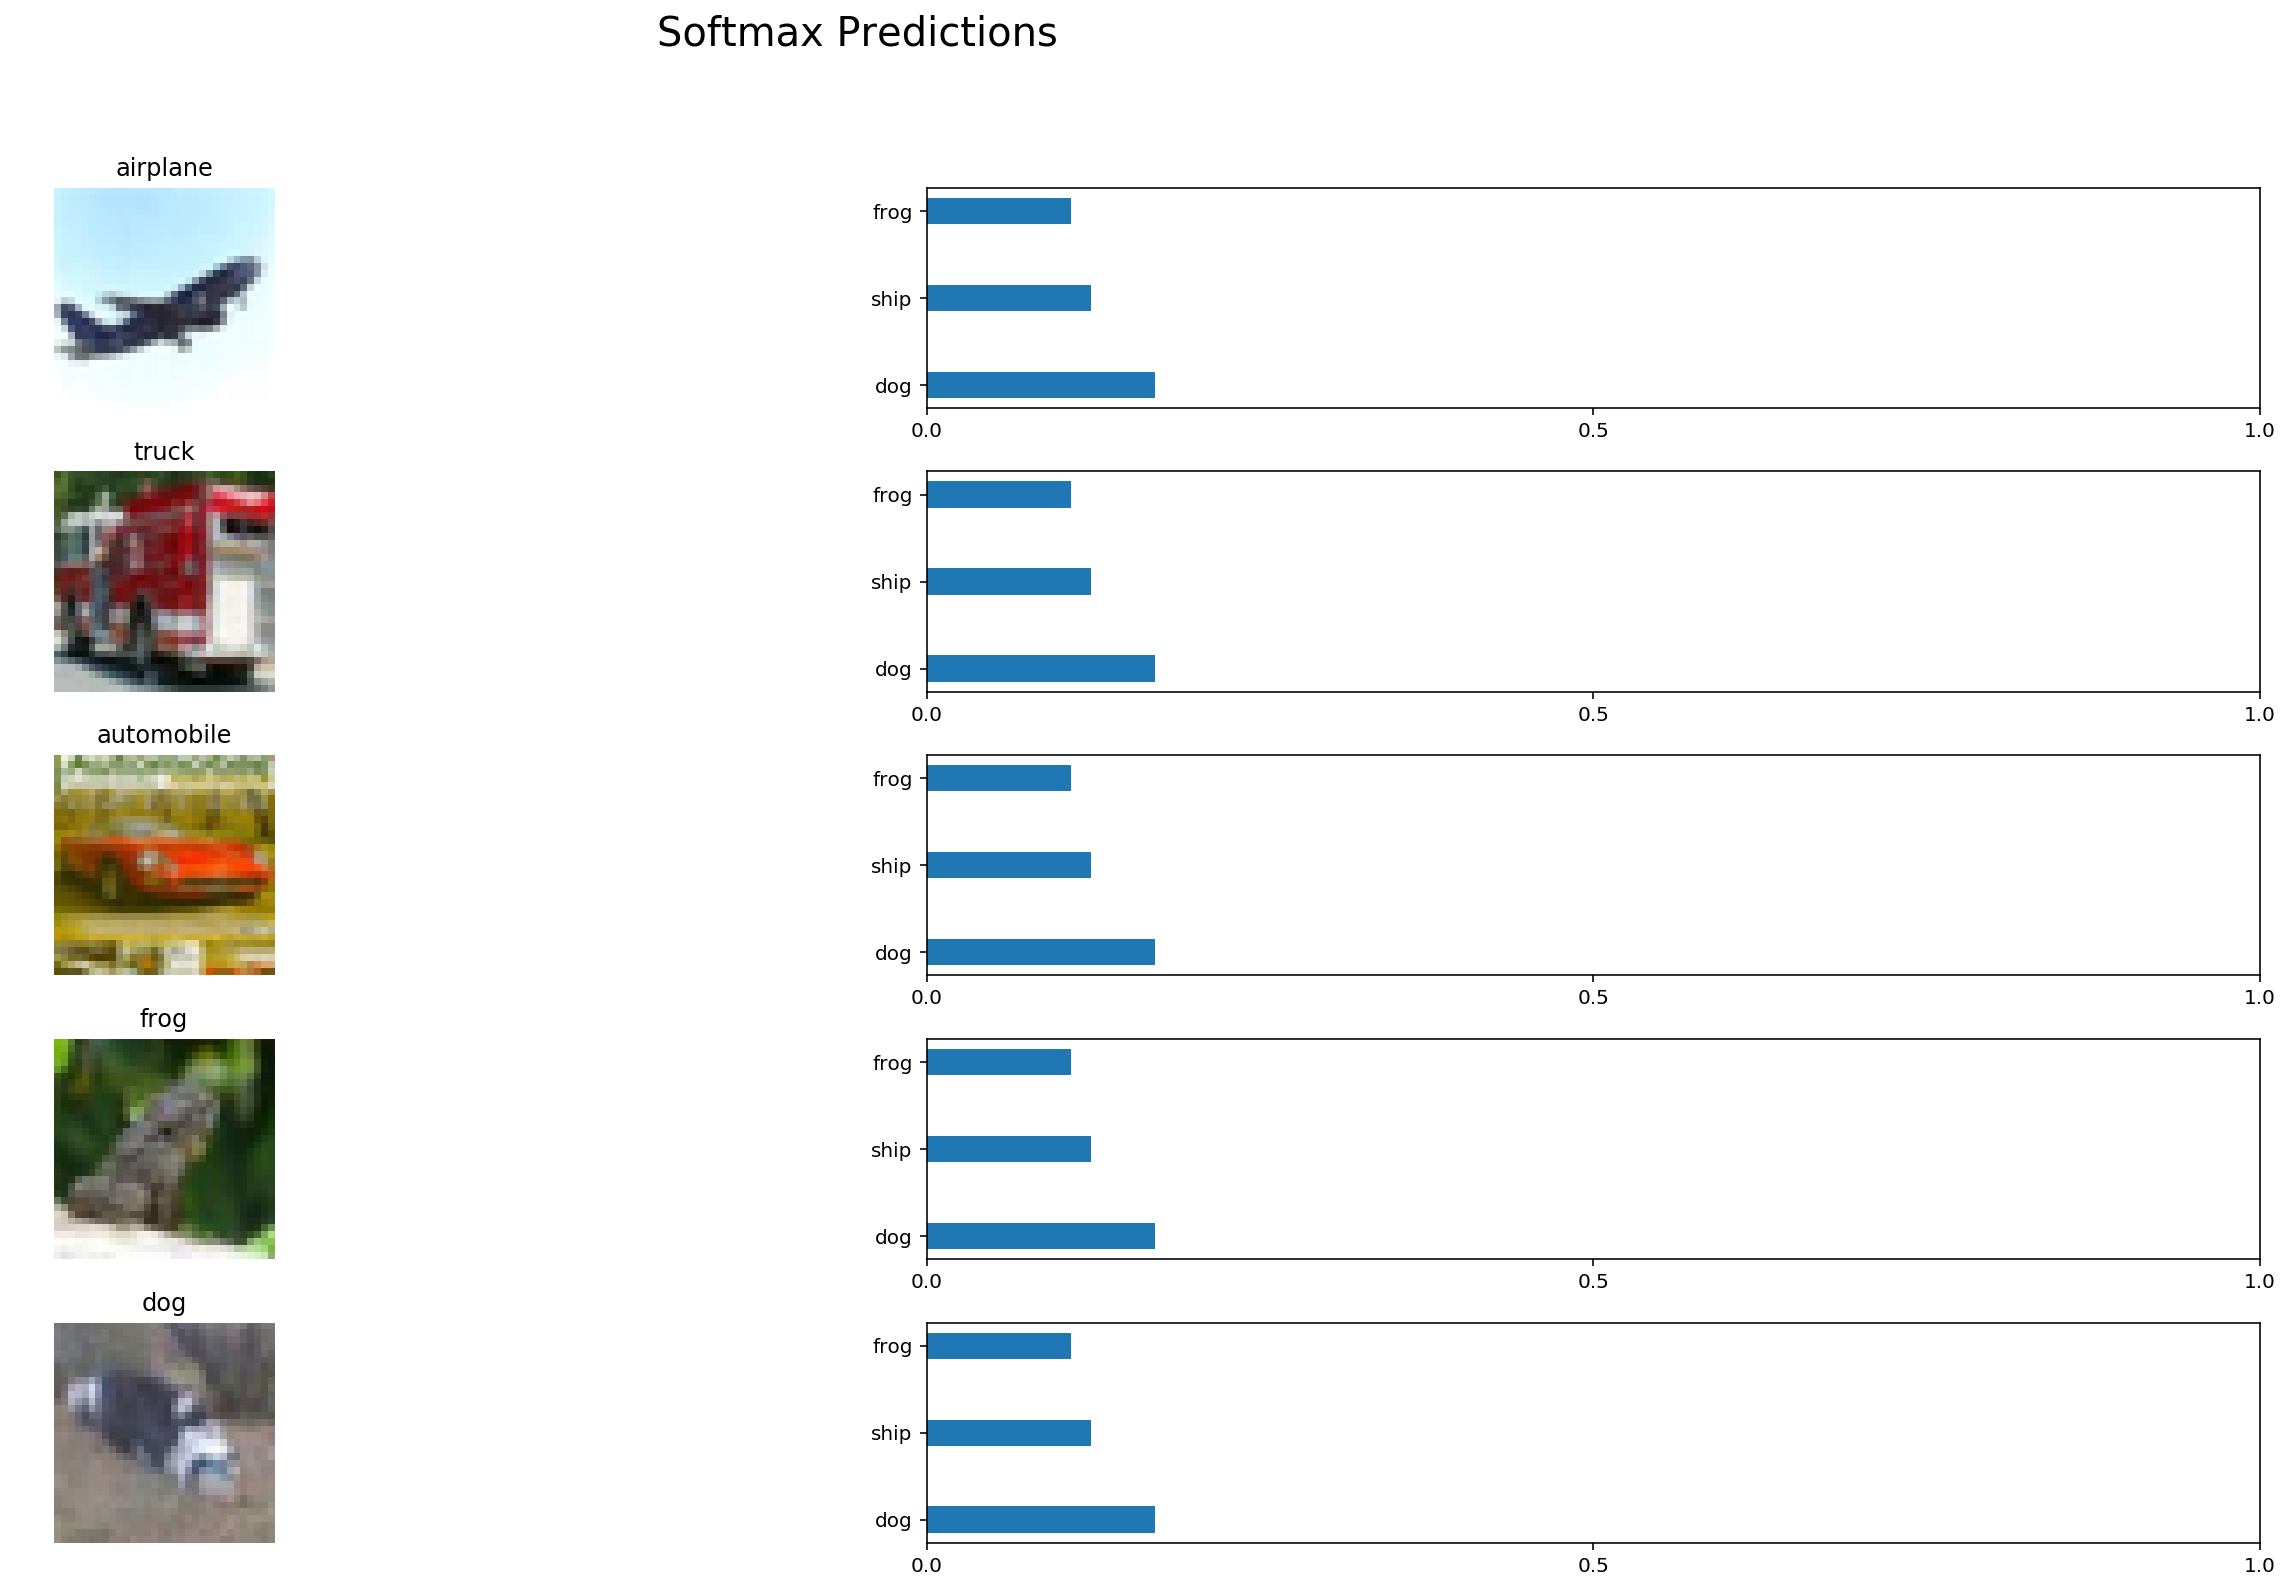